<div style="display: flex; gap: 10px;">
  <img src="../packages/cadfiles/HOOPS_AI.jpg" style="width: 20%;">
</div>

# HOOPS AI: Encoder Module

## Overview

The `cadencoder` module provides functionality for extracting and encoding geometric and topological data from CAD models. It converts complex 3D boundary representation (B-rep) models into structured data formats that can be used for machine learning applications.

The main class in this module is `BrepEncoder`, which extracts various features from a B-rep model and saves them using a storage handler.

## BrepEncoder

The `BrepEncoder` class is responsible for computing and persisting geometry and topology data from a B-rep. It provides methods (called "push" methods) that extract specific features from the model and if the DataStorage object is provided, it can storage it in a compressed optimal file. Very handy when working with large datasets. 

### Constructor

```python
def __init__(self, brep_access: BrepAccess, storage_handler: DataStorage = None):
    """
    Args:
        brep_access: BrepAccess - The B-Rep geometry data source interface (from cadaccess module)
        storage_handler: DataStorage - Optional, Object to load/save data from disk or memory
    """
```

In [1]:
import hoops_ai
import os

hoops_ai.set_license(hoops_ai.use_test_license(), validate = True)

✓ HOOPS AI License: Valid


In [2]:
import pathlib

nb_dir = pathlib.Path.cwd()
    
output_dir =   nb_dir.joinpath("out")
# Create output directory if it does not exist
if not output_dir.exists():
    os.makedirs(output_dir)

## Initialize the HOOPSLoader and set the brep options

In [3]:
from hoops_ai.cadaccess import HOOPSLoader, HOOPSModel, HOOPSTools

In [4]:

cad_loader =  HOOPSLoader()

cad_filename = nb_dir.parent.joinpath("packages", "cadfiles", "pn_verschr_r1.prt.1")
cad_model = cad_loader.create_from_file(str(cad_filename))

# Specify the brep Options and modify the model

hoopstools  = HOOPSTools()


# Working with BReps
brep_options = hoopstools.brep_options()
brep_options["force_compute_uv"] =  True       
brep_options["force_compute_3d"] =  True 
hoopstools.adapt_brep(cad_model, brep_options )



# Encode the Brep data into structured python data

In [5]:
from hoops_ai.cadencoder import BrepEncoder
brep_encoder = BrepEncoder(cad_model.get_brep())

#### Graph and Topology Methods

##### `push_face_adjacency_graph() -> nx.Graph`

Builds and stores a face adjacency graph from the B-rep model. This graph represents the topology of the model where nodes are faces and edges connect adjacent faces.


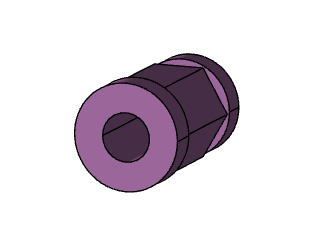

DiGraph with 21 nodes and 46 edges


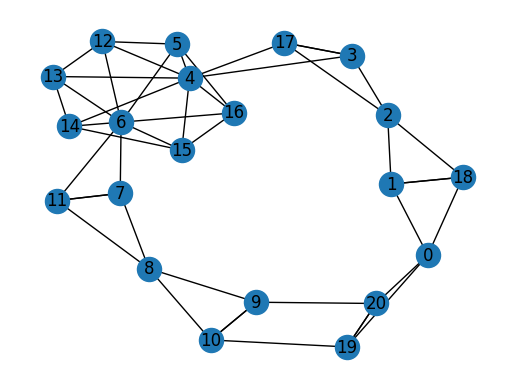

In [6]:

hoopstools.exportStreamCache(cad_model, str(output_dir.joinpath("exported_cad_ref1")), is_white_background=True, overwrite=True)   
from IPython.display import Image, display
display(Image(filename=str(output_dir.joinpath("exported_cad_ref1_white.png"))))

adj_graph = brep_encoder.push_face_adjacency_graph()
print(adj_graph)

import networkx as nx
import matplotlib.pyplot as plt

pos = nx.kamada_kawai_layout(adj_graph)


nx.draw_networkx(adj_graph, pos, arrows=False)   # draw nodes, edges, labels
plt.axis('off')                         # turn off axes for clarity
plt.show()


In [7]:
from hoops_ai.insights import CADViewer

In [8]:
#help(CADViewer)
viewer = CADViewer(static_folder=output_dir, display_mode = 'inline')
viewer.load_scs_file(str(output_dir.joinpath("exported_cad_ref1.scs")))
viewer.show()

In [9]:
viewer.set_face_color([12], [255,0,0])

In [10]:
all_neighbors = list(set(adj_graph.successors(12)).union(adj_graph.predecessors(12)))
print(all_neighbors)
viewer.set_face_color(all_neighbors, [0,0,255])

[5, 4, 13, 6]


![](../packages/cadfiles/encoder_face_with_neighbors.png)

##### `push_face_attributes() -> int`

Extracts and stores various face attributes, including face types, areas, and loop counts.

- **Returns**: 0 on success
- **Storage Keys**: "face_types", "face_areas", "face_loops", and metadata "descriptions/face_types"
- **Dependencies**: Requires "face_indices" to be already stored
- **Storage Format**: 1D numpy arrays for each attribute type

In [11]:
[face_types, face_areas, face_loops], face_types_descr = brep_encoder.push_face_attributes()
print("face_types", face_types)
print("face_areas", face_areas)
print("face_loops", face_loops)
print("face_types_descr", face_types_descr)

face_types [0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 1 2 2]
face_areas [ 43.911655 141.3149    75.277115  51.831074  24.732485  57.030937
  19.963306  12.871587  28.228918  39.265965  39.265965  12.871587
  57.030937  57.030933  57.030937  57.030937  57.030933  51.831074
 141.3149    10.575602  10.575602]
face_loops [2 1 2 1 2 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1]
face_types_descr {0: 'Plane', 1: 'Cylinder', 2: 'Cone'}


##### `push_edge_attributes() -> List[ndarray], Dict`

Extracts and stores various edge attributes, including edge types, lengths, dihedral angles, and convexities.

- **Storage Keys**: "edge_types", "edge_lengths", "edge_dihedral_angles", "edge_convexities", and metadata "descriptions/edge_types"
- **Storage Format**: 1D numpy arrays for each attribute type

In [12]:
[edge_types_np, edge_lengths_np, edge_dihedrals_np, edge_convexities_np], edge_type_descrip = brep_encoder.push_edge_attributes()
print("edge_types_np", edge_types_np)
print("edge_lengths_np", edge_lengths_np)
print("edge_dihedrals_np", edge_dihedrals_np)
print("edge_convexities_np", edge_convexities_np)
print("edge_type_descrip", edge_type_descrip)

edge_types_np [1 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 1 0
 0 1 1 0 0 0 0 0 0]
edge_lengths_np [14.137167   14.137167    7.8539815   7.8539815  18.          7.8539815
 18.         17.278759   17.278759    7.8539815   3.          3.
 17.278759   17.278759    5.196152    5.196152    5.196152    5.196152
  5.196152    5.196152   10.97561     5.196152   10.97561     5.196152
  5.196152    5.196152    5.196152    5.196152   12.566371   12.566371
  1.0243902  12.566371    1.0243902  15.707963   15.707963   12.566371
  2.5         2.5        15.707963   15.707963   10.97561    10.97561
 10.97561    10.97561     0.70710677  0.70710677]
edge_dihedrals_np [ 7.8539819e-01  7.8539819e-01 -1.5707964e+00 -1.5707964e+00
  2.4492937e-16  1.5707964e+00  0.0000000e+00 -1.5707964e+00
 -1.5707964e+00  1.5707964e+00  0.0000000e+00  2.4492937e-16
  1.5707964e+00  1.5707964e+00 -1.5707964e+00 -1.5707964e+00
 -1.5707964e+00 -1.5707964e+00 -1.5707964e+00 -1.5707964e+00
  1.0471976

##### `push_facegrid(ugrid: int = 5, vgrid: int = 5) -> np.ndarray`

Samples points, normals, and inside/outside information on a grid across each face.

- **Parameters**:
  - `ugrid`: Number of grid points in the U direction (default: 5)
  - `vgrid`: Number of grid points in the V direction (default: 5)
- **Storage Key**: "face_uv_grids"
- **Storage Format**: facecount×ugrid×vgrid×feature_dim numpy array of sampled data


##### `push_curvegrid(ugrid: int = 5) -> np.ndarray`

Samples points along edges at regular intervals.

- **Parameters**:
  - `ugrid`: Number of sample points along each edge (default: 5)
- **Returns**: 0 on success
- **Storage Format**: edgecount×ugrid×feature_dim numpy array of sampled data

In [13]:
print("--"*32)
face_grids = brep_encoder.push_facegrid(ugrid=4, vgrid=4)
print("face_grids\n", face_grids[0])

print("--"*32)
edge_grids = brep_encoder.push_curvegrid(ugrid=3)
print("edge_grids\n", edge_grids[0])

----------------------------------------------------------------
face_grids
 [[[ 2.2000000e+01  3.0003281e+00  3.0152695e+00  1.0000000e+00
    0.0000000e+00  0.0000000e+00  1.0000000e+00]
  [ 2.2000000e+01  3.0003281e+00  1.5076348e+00  1.0000000e+00
    0.0000000e+00  0.0000000e+00  1.0000000e+00]
  [ 2.2000000e+01  3.0003281e+00  0.0000000e+00  1.0000000e+00
    0.0000000e+00  0.0000000e+00  1.0000000e+00]
  [ 2.2000000e+01  3.0003281e+00 -1.5076348e+00  1.0000000e+00
    0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 2.2000000e+01  1.5001640e+00  3.0152695e+00  1.0000000e+00
    0.0000000e+00  0.0000000e+00  1.0000000e+00]
  [ 2.2000000e+01  1.5001640e+00  1.5076348e+00  1.0000000e+00
    0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 2.2000000e+01  1.5001640e+00  0.0000000e+00  1.0000000e+00
    0.0000000e+00  0.0000000e+00  0.0000000e+00]
  [ 2.2000000e+01  1.5001640e+00 -1.5076348e+00  1.0000000e+00
    0.0000000e+00  0.0000000e+00  0.0000000e+00]]

 [[ 2.2000000e+01  1.77

In [14]:
edges_path = brep_encoder.push_face_pair_edges_path(5)

In [15]:
print(edges_path[0][15])

[ 1  3  4 39 10]


In [16]:
viewer.terminate()

In [17]:
help(brep_encoder)

Help on BrepEncoder in module hoops_ai.cadencoder.brep_encoder object:

class BrepEncoder(builtins.object)
 |  BrepEncoder(brep_access: hoops_ai.cadaccess.brep_access.BrepAccess, storage_handler: hoops_ai.storage.datastorage.data_storage_handler_base.DataStorage = None)
 |  
 |  A single class to compute + persist geometry and topology data.
 |  
 |  Each 'push_*' method:
 |    1) Looks at `storage_handler.get_keys()`.
 |    2) Ensures schema definition exists for the data.
 |    3) Computes the result, saves to storage.
 |    4) Returns 0, discarding any data from memory after storage.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, brep_access: hoops_ai.cadaccess.brep_access.BrepAccess, storage_handler: hoops_ai.storage.datastorage.data_storage_handler_base.DataStorage = None)
 |      Args:
 |          datasource: The B-Rep or geometry data source (e.g. reading from CAD).
 |          storage_handler: Object to load/save data from disk.
 |  
 |  push_average_face_pair_angle_his